In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [193]:
#EWMA formula, acts as basis to compare other models
def ewma_predict_Days(volatility, lambda_, days, loss):
    predicted = []
    true = []
    start = len(volatility) - days
    # print(start)
    for i in range(start, len(volatility)):
        historical = volatility.iloc[:i]
        # print("historical: ", historical)
        ewma_value = historical.ewm(alpha=lambda_).mean().iloc[-1]
        # print("ewma value: ", ewma_value)
        true.append(volatility.iloc[i])
        predicted.append(ewma_value)
    # print(true)
    # print(predicted)
    if loss == "MSE":
        return np.mean((np.array(true)-np.array(predicted))**2)
    else:
        return None

In [194]:
#Load in AAPL data, make returns, variance, and volatility
df = pd.read_csv("data_files/AAPL_combined.csv.gz")
AAPL_returns = pd.DataFrame({
    "time_stamp": df["Unnamed: 0"],
    "log_return": np.log(1+(df['4. close']-df['1. open'])/df['1. open'])
})
AAPL_returns['time_stamp'] = pd.to_datetime(AAPL_returns['time_stamp'], errors='coerce')
daily_variance_AAPL = AAPL_returns.groupby(AAPL_returns['time_stamp'].dt.floor("1D"))["log_return"].var()


Text(0.5, 1.0, 'Apple Returns')

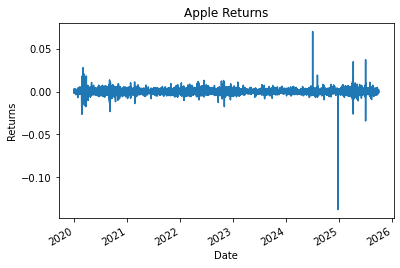

In [195]:
#Plot returns
AAPL_returns.set_index("time_stamp", inplace=True)
AAPL_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Apple Returns")

Text(0.5, 1.0, 'Apple Variance')

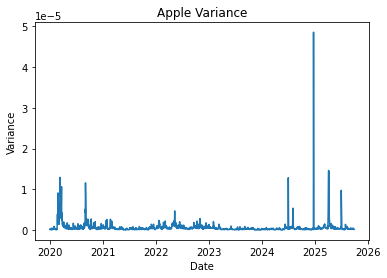

In [196]:
#Plot variance
plt.plot(daily_variance_AAPL.index, daily_variance_AAPL.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("Apple Variance")

Text(0.5, 1.0, 'Apple Volatility')

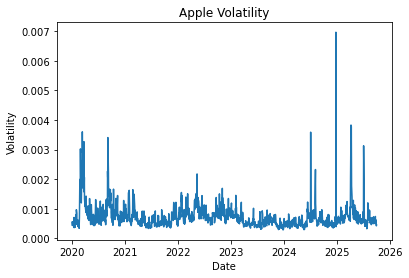

In [197]:
#Plot volatility
daily_volatility_APPL = np.sqrt(daily_variance_AAPL)
plt.plot(daily_volatility_APPL.index, daily_volatility_APPL.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Apple Volatility")

In [198]:
#Use ewma and find the error in predicting the latest 20 days
mse_APPL = ewma_predict_Days(daily_volatility_APPL, 0.94, 20, "MSE")
print("MSE: ", mse_APPL)

MSE:  1.0911267691521766e-08


In [199]:
#Trying to do covariance correlation, issues with small numbers, become NA
APPL_daily_variance = pd.DataFrame({
    "timestamp": daily_variance.index,
    "variance": daily_variance.values

})
np.corrcoef(APPL_daily_variance.variance[0], APPL_daily_variance.variance[1])
APPL_daily_variance.variance[0]
# for i in range(len(APPL_daily_variance)-1):
#     print(APPL_daily_variance.variance[i])
timestamp = []
correlation = []
for i in range(len(APPL_daily_variance)-1):
    timestamp.append([APPL_daily_variance.timestamp[i], APPL_daily_variance.timestamp[i+1]])
    correlation.append(np.corrcoef(APPL_daily_variance.variance[i], APPL_daily_variance.variance[i+1])[0,1])
APPL_correlation = pd.DataFrame({
    "timestamps": timestamp,
    "correlation": correlation
})
APPL_correlation

/Users/gabrielawurgaft/opt/miniconda3/envs/cse217a/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/gabrielawurgaft/opt/miniconda3/envs/cse217a/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/gabrielawurgaft/opt/miniconda3/envs/cse217a/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,timestamps,correlation
0,"[2020-01-02 00:00:00, 2020-01-03 00:00:00]",NaN
1,"[2020-01-03 00:00:00, 2020-01-06 00:00:00]",NaN
2,"[2020-01-06 00:00:00, 2020-01-07 00:00:00]",NaN
3,"[2020-01-07 00:00:00, 2020-01-08 00:00:00]",NaN
4,"[2020-01-08 00:00:00, 2020-01-09 00:00:00]",NaN
...,...,...
1438,"[2025-09-23 00:00:00, 2025-09-24 00:00:00]",NaN
1439,"[2025-09-24 00:00:00, 2025-09-25 00:00:00]",NaN
1440,"[2025-09-25 00:00:00, 2025-09-26 00:00:00]",NaN
1441,"[2025-09-26 00:00:00, 2025-09-29 00:00:00]",NaN


In [183]:
df = pd.read_csv("data_files/BEP_combined.csv.gz")
df.columns
BEP_returns = pd.DataFrame({
    "time_stamp": df["Unnamed: 0"],
    "log_return": np.log(1+(df['4. close']-df['1. open'])/df['1. open'])
})
BEP_returns['time_stamp'] = pd.to_datetime(BEP_returns['time_stamp'], errors='coerce')
daily_variance_BEP = BEP_returns.groupby(BEP_returns['time_stamp'].dt.floor("1D"))["log_return"].var()

Text(0.5, 1.0, 'BEP Returns')

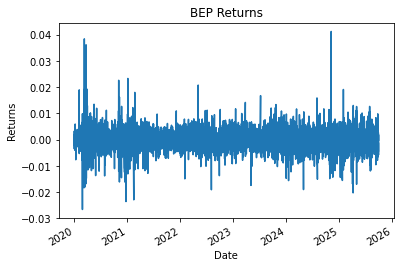

In [184]:
BEP_returns.set_index("time_stamp", inplace=True)
BEP_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("BEP Returns")

Text(0.5, 1.0, 'BEP Variance')

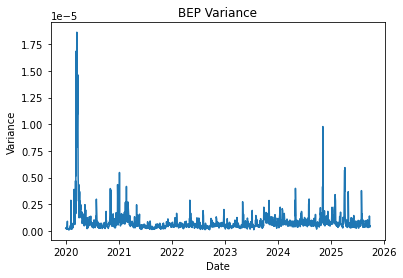

In [185]:
plt.plot(daily_variance_BEP.index, daily_variance_BEP.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("BEP Variance")

Text(0.5, 1.0, 'BEP Volatility')

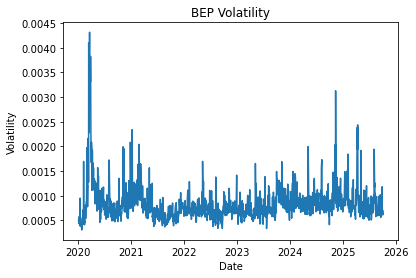

In [186]:
daily_volatility_BEP = np.sqrt(daily_variance_BEP)
plt.plot(daily_volatility_BEP.index, daily_volatility_BEP.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("BEP Volatility")

In [188]:
mse_BEP = ewma_predict_Days(daily_volatility_BEP, 0.94, 20, "MSE")
print("BEP MSE: ", mse_BEP)

BEP MSE:  5.497451390562223e-08


Text(0.5, 1.0, 'LLY Returns')

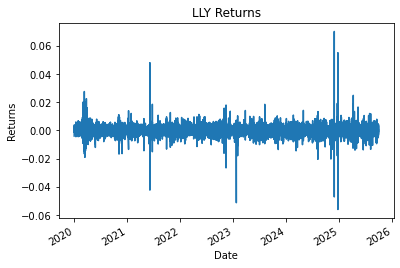

In [189]:
df = pd.read_csv("data_files/LLY_combined.csv.gz")
df.columns
LLY_returns = pd.DataFrame({
    "time_stamp": df["Unnamed: 0"],
    "log_return": np.log(1+(df['4. close']-df['1. open'])/df['1. open'])
})
LLY_returns['time_stamp'] = pd.to_datetime(LLY_returns['time_stamp'], errors='coerce')
daily_variance_LLY = LLY_returns.groupby(LLY_returns['time_stamp'].dt.floor("1D"))["log_return"].var()

LLY_returns.set_index("time_stamp", inplace=True)
LLY_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("LLY Returns")


Text(0.5, 1.0, 'LLY Variance')

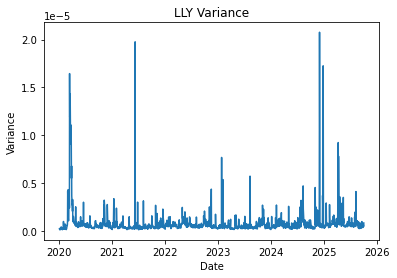

In [190]:
plt.plot(daily_variance_LLY.index, daily_variance_LLY.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("LLY Variance")

Text(0.5, 1.0, 'LLY Volatility')

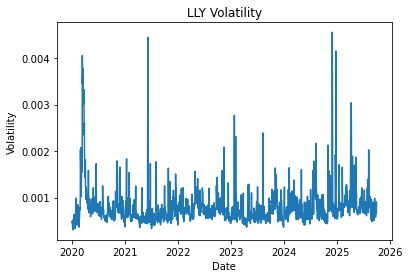

In [191]:
daily_volatility_LLY = np.sqrt(daily_variance_LLY)
plt.plot(daily_volatility_LLY.index, daily_volatility_LLY.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("LLY Volatility")

In [192]:
mse_LLY = ewma_predict_Days(daily_volatility_LLY, 0.94, 20, "MSE")
print("MSE LLY: ", mse_LLY)

MSE LLY:  2.2330775595107893e-08
